In [85]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import cufflinks as cf
#cf.go_offline()
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import rcParams
from _plotly_future_ import v4_subplots

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

import plotly as pl
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
import sklearn.linear_model as linear_model
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import HTML, display
import category_encoders as ce
pd.options.display.max_columns = None
import missingno as msno
from numpy.random import choice
np.random.seed(99)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import mglearn
from sklearn.metrics import accuracy_score

In [2]:
%store -r nnn_newdf

In [3]:
df=nnn_newdf.copy()

In [4]:
#Let's split the model into categorical features and non categorical features
nom_data_df =df.select_dtypes(include=['object']).copy()
ordinal_data_df=df.select_dtypes(include=['int64','float64']).copy()
pred_df=nnn_newdf[['hh_inco']]
#remove the target varibale from the ordinal and continuous data frames 
ordinal_data_df=ordinal_data_df.drop(columns=['hh_inco'])

In [ ]:
#encoding the data using one of three methods 

'''
1. One hot encoding 
Since there are many columns with more number of dimensions, the problem might face curse of dimensionality

2. Binary encoding
Works welll on the oridnal data convert each integer to binary digits. 
Each binary digit gets one column. Some info loss but fewer dimensions. Ordinal.

3. Hashing 
works well if there are many distinct categories. There might be collisions if there are some overlapping columns. But the 
curse of dimensionality is solved.Like OneHot but fewer dimensions, some info loss due to collisions. Nominal, ordinal.

4. Backward difference encoding
the mean of the dependent variable for a level is compared with the mean of the dependent variable for the prior level. 
'''

def onehotencoded(df):
    return pd.get_dummies(df)

def binaryencoded(df):
    #create a binary encoded object
    be=ce.BinaryEncoder(df.columns.values)
    #fit and transform the data
    return be.fit_transform(df)
    
def hashingencoded(df):
    #create a hashing encoder object
    he=ce.HashingEncoder(df.columns.values)
    #fit and transofrm on the data
    return he.fit_transform(df)

def backwarddifferenceencoded(df):
    #create a backward deference encoding
    bd=ce.BackwardDifferenceEncoder(df.columns.values)
    return bd.fit_transform(df)

In [22]:
def splitdata(dependent,independent):
    # split data into train+validation set and test set
    X_trainval, X_test, y_trainval, y_test = train_test_split(
    dependent, independent, random_state=0)
    # split train+validation set into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)

    return (X_trainval, X_test, y_trainval, y_test),(X_train, X_valid, y_train, y_valid)

In [183]:
def scalingdata(X_train,X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,X_test

In [ ]:
print("There are about ",len(df.columns.values)," columns in the original data set")
#Let's do Recursuve feature elimination 
'''
There is a filter-based method.
1. Pearson correlation
We check the absolute value of the Pearson’s correlation between the target and numerical features in our dataset.
We keep the top n features based on this criterion.

2, CHI_squared
In this method, we calculate the chi-square metric between the target and 
the numerical variable and only select the variable with the maximum chi-squared values.

3. Recursive feature elimination 
First, the estimator is trained on the initial set of features and the importance of each feature is obtained 
either through a coef_ attribute or through a feature_importances_ attribute. Then, 
the least important features are pruned from current set of features. That procedure is recursively
repeated on the pruned set until the desired number of features to select is eventually reached.
 

'''

# so let's use Recursive feature elimination 

def rfe(n_features_to_select,X_train,y_train):
    rfe_selector = RFE(estimator=LogisticRegression(
        penalty="l1"), n_features_to_select=n_features_to_select, step=10, verbose=5)
    rfe_selector.fit(X_train, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    return rfe_feature

In [19]:
# now let's create three data sets 
#one feach for onehotencoded,hashingcncoded and backwrd difference_encoded

df_onehot=pd.concat([ordinal_data_df,onehotencoded(nom_data_df)],axis=1)
df_hash=pd.concat([ordinal_data_df,hashingencoded(nom_data_df)],axis=1)
df_bd=pd.concat([ordinal_data_df,backwarddifferenceencoded(nom_data_df)],axis=1)
df_bd.drop(columns=['intercept'],inplace=True)

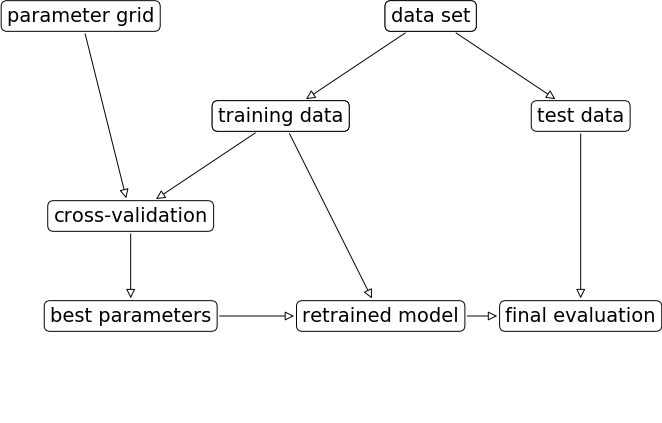

In [39]:
# so let's follow the below method but including RFE and not including RFE
mglearn.plots.plot_grid_search_overview()

In [140]:
#now let's do recursive feature elimnation
#let's set number of features to select
num_features_select=15
print("Number of columns in the encoded data set",df_bd.shape[1])
features_selected=rfe(num_features_select,df_bd,pred_df)
data=df_bd[features_selected]

Number of columns in the encoded data set 43
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Fitting estimator with 23 features.
15 selected features


Size of training set: 5608 size of validation set: 1870 size of test set: 2493



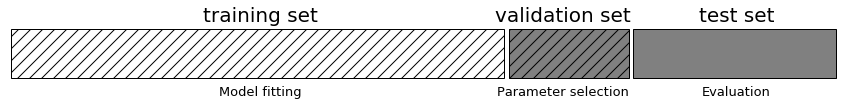

In [162]:
#let's use data to split into train, test and validation
(X_trainval, X_test, y_trainval, y_test),(X_train, X_valid, y_train, y_valid)=splitdata(data,pred_df)
print("Size of training set: {} size of validation set: {} size of test set:"
" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

mglearn.plots.plot_threefold_split()

In [160]:
#scaling the data 
#X_train,X_test,X_valid=scalingdata(X_train,X_test,X_valid)

In [133]:
#steps to follow 
#choose 1 method of encoding 
#do Recursive Feature eleimination [select best columns]
#split the data
#scale the data  
#now build the model using GridSearchCV. Do a parameter tuning using Validation data
#again build the model with best parameter 
# evaluate the model on the test data
#evalutaion using Confusion matrix, Accuracy, micro and macro[precision, recall and f1 score.]

In [164]:
best_score=0
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # for each combination of parameters, train an SVC
    model = LogisticRegression(solver="lbfgs",multi_class="multinomial",C=C)
    model.fit(X_train, y_train)
    
    score = accuracy_score(y_valid,model.predict(X_valid))
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameters = {'C': C}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
print(best_parameters)

model = LogisticRegression(solver="lbfgs",multi_class="multinomial",C=best_parameters['C'])
model.fit(X_trainval, y_trainval)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuray Score on test dataset
accuracy_test= accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)



{'C': 100}
Target on train data [15.  7.  9. ...  9.  7. 14.]
accuracy_score on train dataset :  0.6314194008559201
Target on test data [6. 2. 9. ... 6. 7. 3.]
accuracy_score on test dataset :  0.6337745687926193


In [169]:
y_train['hh_inco'].value_counts()
# as you can see the score 

15.0    951
6.0     595
7.0     594
14.0    549
8.0     462
9.0     386
4.0     384
5.0     381
3.0     322
10.0    301
2.0     237
12.0    179
1.0     168
13.0     99
Name: hh_inco, dtype: int64

In [227]:
#let's use Grid search CV with 10 folds
X_train, X_test, y_train, y_test = train_test_split(
data, pred_df, random_state=0,test_size=0.5)

X_train,X_test=scalingdata(X_train,X_test)

In [235]:
grid={"C":np.logspace(-3,3,8)} 
logreg=LogisticRegression(solver="lbfgs",multi_class="multinomial")
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0}
accuracy : 0.8058174523570713


In [230]:
print("Best estimator:\n{}".format(logreg_cv.best_estimator_))

Best estimator:
LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [229]:


# predict the target on the train dataset
predict_train = logreg_cv.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = logreg_cv.predict(X_test)
print('Target on test data',predict_test) 

# Accuray Score on test dataset
accuracy_test= accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Target on train data [15.  1.  6. ... 15.  7. 15.]
accuracy_score on train dataset :  0.8300902708124374
Target on test data [ 6.  2.  9. ... 14.  7. 15.]
accuracy_score on test dataset :  0.8080625752105897


AttributeError: 'QuadMesh' object has no property 'xlabel'

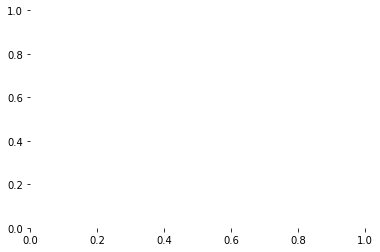

In [248]:
# convert to DataFrame
results = pd.DataFrame(logreg_cv.cv_results_)
# show the first 5 rows
results

#scores = np.array(results.mean_test_score).reshape(8, 1)
sns.heatmap(scores, xlabel='C',cmap="viridis")

In [238]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_test))

              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       132
         2.0       0.86      0.93      0.89       209
         3.0       0.91      0.89      0.90       312
         4.0       0.87      0.88      0.87       321
         5.0       0.86      0.70      0.77       338
         6.0       0.81      0.88      0.85       540
         7.0       0.81      0.88      0.84       515
         8.0       0.88      0.84      0.86       417
         9.0       0.70      0.84      0.77       319
        10.0       0.69      0.59      0.64       264
        12.0       0.50      0.22      0.31       161
        13.0       0.57      0.38      0.46        71
        14.0       0.72      0.66      0.69       526
        15.0       0.82      0.93      0.87       861

    accuracy                           0.81      4986
   macro avg       0.78      0.76      0.76      4986
weighted avg       0.80      0.81      0.80      4986



In [239]:
sns.heatmap(results)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''